# Multi-genre classification of heavy metal lyrics

The aim of this notebook is to demonstrate a machine learning approach to tagging heavy metal songs with genre labels based on their lyrics alone. The task is to develop a model which will predict for a given piece of text which genre(s) describe the text well.

This notebook will implement and discuss the usage of:
* Binary relevance as a multi-label classification framework
* Multi-label classification cross-validation and evaluation metrics
* Bag-of-words text representation (and why it is favorable over word embeddings for this task)
* Oversampling methods to curb the effects of imbalanced datasets
* A wide range of different classification models including:
    * Logistic regression
    * Bayesian methods
    * Ensemble methods
    * Neural networks

# Table of contents

1. [Imports](#imports)

1. [Data](#data)

1. [Multi-label classification tools](#mlctools)

1. [Evaluation metrics](#metrics)

1. [Pipeline](#pipeline)

1. [Hyperparameter tuning](#tuning)

1. [Logistic regression](#logreg)

1. [SGD classifier](#sgd)

1. [Naive Bayes](#naivebayes)

    * [Multinomial Naive Bayes](#multinomialnb)

    * [Complement Multinomial Naive Bayes](#complementnb)

    * [Bernoulli Naive Bayes](#bernoullinb)

1. [Random forest](#rf)

1. [Gradient boosted model](#gbm)

1. [Neural network](#nn)

1. [Stacked model](#stacking)

1. [Test on new lyrics](#test)

<a id='imports'></a>
# Imports

In [15]:
import glob
import os
import re
from copy import deepcopy
import numpy as np
import pandas as pd
import scipy
import itertools

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, \
confusion_matrix, multilabel_confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB

from skmultilearn.model_selection import IterativeStratification
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset

from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

import lightgbm as lgb


import sys
sys.path.append('../scripts/')

from nlp import tokenize
from mlsol import MLSOL
import lyrics_utils as utils

<a id='data'></a>
# Data

See the previous chapters for more discussion about the data set. The data set is formatted as an array comprised of one independent variable (lyrics, retrieved from [Dark Lyrics](http://darklyrics.com)) and five dependent variable labels (genres, retrieved from [Metal-Archives](https://www.metal-archives.com)), for each row (song). Here are some things to keep in mind about the data:
* Each song can belong to any one or more, or none, of the genres. For example, a song can be labeled as thrash metal, or both thrash and power metal, and so on, or it can be unlabeled; it can therefore be predicted to be any combination of labels, or unlabeled, as well. This makes the task of tagging song lyrics with the appropriate genre labels a multi-label classification problem.
* The dataset is multi-lingual, since heavy metal spans many languages around the world. This will affect classification since there are correlations between genres and country of origin, as show in the previous chapter.
* The length of song lyrics can vary wildly, but this won't be a big issue in a bag-of-words representation.

In [2]:
df = pd.read_csv('../bands-ml-10pct.csv')
X = df.pop('lyrics').values
y = df.values
genres = df.columns
print(f"number of songs: {X.shape[0]}")
print(f"number of labels: {y.shape[1]}")
print(f"labels: {list(genres)}")

number of songs: 1355
number of labels: 4
labels: ['black', 'death', 'power', 'thrash']


<a id='mlctools'></a>
# Multi-label classification tools

**Binary relevance** is the simplest method of classifying multiple labels at once; it trains an independent classifier for each label, breaking the multi-label problem down into many binary classification problems ([Zhang, M., Li, Y., Liu, X., et al, 2018](http://palm.seu.edu.cn/zhangml/files/FCS'17.pdf)). In this context a binary classifier would be trained on each genre, and a song's genre tags predicted by concatenating the predictions of all genre classifiers. The advantage of this method is that the number of classifiers needed is equal to the number of labels, so the computational cost scales linearly with how many labels we want to predict. However, by assuming that the labels are independent, this method fails to capture correlations between labels. For example, the "heavy" and "power" genre labels are more likely to appear together, so an song's likelihood of being tagged as power metal should be higher if it is also tagged as heavy metal as opposed to, say, black metal. Another issue is that each binary classifier will face a class imbalance problem due to the sparsity of genre tags.

In the **classifier chain** method, a classifier is trained on one label and its output is fed as an additional feature to the next label, and so on until all labels have been exhausted ([Read, J., Pfahringer, B., Holmes., G, Frank, E. 2011](https://www.cs.waikato.ac.nz/~eibe/pubs/chains.pdf)). This again requires only as many classifiers as there are labels, but unlike binary relevance it does learn correlations between labels. However, the correlations it is capable of learning can vary with different chain orders.

Unlike the above two methods, which transform the multi-label problem into multiple independent binary classification problems, the **label powerset** method transforms it into a single multi-class problem by treating every combination of labels as its own class. For example, from the genres in the metal lyrics dataset, "black" + "death", "black" + "power", "black" + "death" + "power" would each yield a new class. This tackles the issue of correlated labels head-on by treating correlations as classes on their own, but comes at the cost of having smaller class sizes to train on and consequently an even bigger class imbalance problem. This issue inspired the **RAndom k-labELsets (RAKEL)** method, which uses an ensemble of classifiers, each trained on a random subset of labels ([Rokach, L., Schclar, A., Itach, E. 2013](https://arxiv.org/ftp/arxiv/papers/1307/1307.1769.pdf)).

In [3]:
class BinaryRelevance:
    def __init__(self, classifier, labels, thresholds=None):
        self.classifier = classifier
        self.labels = labels
        self.classifiers_ = []
        self.thresholds = thresholds

    def fit(self, X, y):
        for i, label in enumerate(self.labels):
            print('training binary classifier for label: {}'.format(label))
            clf = deepcopy(self.classifier)
            clf.fit(X, y[:, i])
            self.classifiers_.append((label, clf))

    def predict(self, X):
        return self._predict(X).astype(int)

    def predict_proba(self, X):
        return self._predict(X, return_prob=True)

    def _predict(self, X, return_prob=False):
        y = np.zeros((X.shape[0], len(self.classifiers_)))
        for i, (label, clf) in enumerate(self.classifiers_):
            if return_prob:
                y[:, i] = clf.predict_proba(X)[:, 1]
            elif self.thresholds is not None:
                y[:, i] = (clf.predict_proba(X)[:, 1] > self.thresholds[i])
            else:
                y[:, i] = clf.predict(X)
        return y

    def cross_validate(self, X, y, n_splits=5, verbose=False):
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
        y_prob, y_valid = np.zeros(y.shape), np.zeros(y.shape)
        for i, label in enumerate(self.labels):
            if verbose:
                print("Training on label '{}'".format(label))
            scores = np.zeros((n_splits, 4))
            confusion_matrices = np.zeros((n_splits, 2, 2))
            for j, (train_idx, valid_idx) in enumerate(kfold.split(X, y[:, i])):
                if verbose:
                    print("Fold {}/{}".format(j + 1, n_splits))
                X_fold_train, y_fold_train = X[train_idx], y[train_idx, i]
                X_fold_valid, y_fold_valid = X[valid_idx], y[valid_idx, i]
                clf = deepcopy(self.classifier)
                clf.fit(X_fold_train, y_fold_train)
                try:
                    y_fold_prob = clf.predict_proba(X_fold_valid)[:, 1]
                except AttributeError:
                    y_fold_prob = clf.predict(X_fold_valid).reshape(-1)
                y_prob[valid_idx, i] = y_fold_prob
                y_valid[valid_idx, i] = y_fold_valid
                y_fold_pred = y_fold_prob.round()
                scores[j, 0] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
                scores[j, 1] = precision_score(y_fold_valid, y_fold_pred)
                scores[j, 2] = recall_score(y_fold_valid, y_fold_pred)
                scores[j, 3] = f1_score(y_fold_valid, y_fold_pred)
                confusion_matrices[j] = confusion_matrix(y_fold_valid, y_fold_pred)
            if verbose:
                avg_accuracy, avg_precision, avg_recall, avg_f1 = scores.mean(axis=0)
                std_accuracy, std_precision, std_recall, std_f1 = scores.std(axis=0)
                print("CV scores:")
                print("Accuracy:    {:.2f} +/- {:.2f}".format(avg_accuracy, std_accuracy))
                print("Precision:   {:.2f} +/- {:.2f}".format(avg_precision, std_precision))
                print("Recall:      {:.2f} +/- {:.2f}".format(avg_recall, std_recall))
                print("F1-score:    {:.2f} +/- {:.2f}".format(avg_f1, std_f1))
                print("Average confusion matrix:")
                print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)
        return MultiLabelClassification(y_valid, y_prob, labels=self.labels)

In [4]:
class ClassifierChain:
    def __init__(self, classifier, labels):
        self.classifier = classifier
        self.labels = labels
        self.classifiers_ = []

    def fit(self, X, y, verbose=False):
        y_chain = np.zeros((y.shape[0], y.shape[1] - 1))
        for i in range(y.shape[1]):
            if verbose:
                print('training binary classifier for label: {}'.format(i))
            X_ = X.copy()
            y_ = y[:, i]
            clf = deepcopy(self.classifier)
            if isinstance(clf, Pipeline):
                for name, step in clf.steps:
                    try:
                        X_ = step.fit_transform(X_)
                    except AttributeError:
                        try:
                            if len(X_.shape) > 1:
                                X_, y_ = step.fit_resample(X_[:, : X_.shape[1]], y_)
                            else:
                                X_, y_ = step.fit_resample(X_, y_)
                        except AttributeError:
                            if i > 0:
                                X_ = np.concatenate((X_, y_chain[:, : i]), axis=1)
                            step.fit(X_, y_)
                            y_pred = step.predict(X_).reshape(-1)
                            print(X_.shape, y_.shape, y_pred.shape)
            else:
                if i > 0:
                    X_ = np.concatenate((X_, y_chain[:, : i]), axis=1)
                clf.fit(X_, y_)
                y_pred = clf.predict(X_).reshape(-1)
            y_chain[:, i] = y_pred
            self.classifiers_.append(clf)

    def predict(self, X):
        return self._predict(X)

    def predict_proba(self, X):
        return self._predict(X, return_prob=True)

    def _predict(self, X, return_prob=False):
        y, y_chain = np.zeros((2, X.shape[0], len(self.classifiers_)))
        for i, clf in enumerate(self.classifiers_):
            X_ = X.copy()
            y_ = y[:, i]
            if isinstance(clf, Pipeline):
                for name, step in clf.steps:
                    try:
                        X_ = step.transform(X_)
                    except AttributeError:
                        try:
                            if len(X_.shape) > 1:
                                X_, y_ = step.resample(X_[:, : X_.shape[1]], y_)
                            else:
                                X_, y_ = step.resample(X_, y_)
                        except AttributeError:
                            if i > 0:
                                X_ = np.concatenate((X_, y_chain[:, : i]), axis=1)
                            y_pred = step.predict(X_).reshape(-1)
                            y_prob = step.predict_proba(X_)[:, 1].reshape(-1)
            else:
                if i > 0:
                    X_ = np.concatenate((X_, y_chain[:, : i]), axis=1)
                y_pred = clf.predict(X_).reshape(-1)
                y_prob = clf.predict_proba(X_)[:, 1].reshape(-1)
            y_chain[:, i] = y_pred
            if return_prob:
                y[:, i] = y_prob
            else:
                y[:, i] = y_pred
        return y

    def cross_validate(self, X, y, n_splits=5, verbose=False):
        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=0)
        y_prob, y_valid = np.zeros(y.shape), np.zeros(y.shape)
        scores = np.zeros((len(self.labels), n_splits, 4))
        confusion_matrices = np.zeros((len(self.labels), n_splits, 2, 2))
        for i, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
            if verbose:
                print("Fold {}/{}".format(i + 1, n_splits))
            X_fold_train, y_fold_train = X[train_idx], y[train_idx]
            X_fold_valid, y_fold_valid = X[valid_idx], y[valid_idx]
            clf = deepcopy(self)
            clf.fit(X_fold_train, y_fold_train)
            try:
                y_fold_prob = clf.predict_proba(X_fold_valid)
            except AttributeError:
                y_fold_prob = clf.predict(X_fold_valid)
            y_prob[valid_idx, :] = y_fold_prob
            y_valid[valid_idx, :] = y_fold_valid
            y_fold_pred = y_fold_prob.round()
            for j, label in enumerate(self.labels):
                scores[j, i, 0] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
                scores[j, i, 1] = precision_score(y_fold_valid, y_fold_pred)
                scores[j, i, 2] = recall_score(y_fold_valid, y_fold_pred)
                scores[j, i, 3] = f1_score(y_fold_valid, y_fold_pred)
                confusion_matrices[j, i] = confusion_matrix(y_fold_valid, y_fold_pred)
        if verbose:
            for j, label in enumerate(self.labels):
                avg_accuracy, avg_precision, avg_recall, avg_f1 = scores[j].mean(axis=0)
                std_accuracy, std_precision, std_recall, std_f1 = scores[j].std(axis=0)
                print("CV scores for label {}:".format(label))
                print("Accuracy:    {:.2f} +/- {:.2f}".format(avg_accuracy, std_accuracy))
                print("Precision:   {:.2f} +/- {:.2f}".format(avg_precision, std_precision))
                print("Recall:      {:.2f} +/- {:.2f}".format(avg_recall, std_recall))
                print("F1-score:    {:.2f} +/- {:.2f}".format(avg_f1, std_f1))
                print("Average confusion matrix:")
                print(confusion_matrices[j].mean(axis=0) / confusion_matrices[j].sum() * n_splits)
        return MultiLabelClassification(y_valid, y_prob, labels=self.labels)

<a id='metrics'></a>
# Evaluation metrics

Since binary relevance involves training independent binary classifiers, each classifier can be evaluated during training and cross-validation using the familiar binary classification metrics.

However, evaluating the overall results requires metrics designed for the multi-label output, which are more complicated than the usual evaluation metrics ([Zhang, M., Zhou, Z. 2014](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkde13rev.pdf)). If $h(\mathbf{x}_i)$ is the model which predicts the labels $Y_i$ based on the independent variables $\mathbf{x}_i$, then over $p$ observations the accuracy, precision, recall, and F scores are defined as

\begin{align}
\mathrm{accuracy}(h) &= \frac{1}{p}\sum_{i=1}^{p}(\mathrm{fraction\ of\ labels\ in\ common}) &= \frac{1}{p}\sum_{i=1}^{p}\frac{|Y_i \cap h(\mathbf{x}_i)|}{|Y_i \cup h(\mathbf{x}_i)|}\\
\mathrm{precision}(h) &= \frac{1}{p}\sum_{i=1}^{p}(\mathrm{fraction\ of\ predicted\ labels\ that\ are\ correct}) &= \frac{1}{p}\sum_{i=1}^{p}\frac{|Y_i \cap h(\mathbf{x}_i)|}{|h(\mathbf{x}_i)|}\\
\mathrm{recall}(h) &= \frac{1}{p}\sum_{i=1}^{p}(\mathrm{fraction\ of\ true\ labels\ that\ were\ predicted\ correctly}) &= \frac{1}{p}\sum_{i=1}^{p}\frac{|Y_i \cap h(\mathbf{x}_i)|}{|Y_i|}\\
\mathrm{F_1\ score}(h) &= \mathrm{harmonic\ mean\ of\ precision\ and\ recall} &= 2 \left[ \frac{\mathrm{precision}(h) \cdot \mathrm{recall}(h)}{\mathrm{precision}(h) + \mathrm{recall}(h)} \right]
\end{align}

Another useful metric is the Hamming loss, which is the mean symmetric difference (non-matching genre tags) between the two sets:

$$\mathrm{Hamming}(h) = \frac{1}{p} \sum_{i=1}^{p} |h(\mathbf{x}_i\Delta Y_i|$$

The receiver operating characteristic (ROC) is a common metric for binary classification problems that can be easily extended to multi-label problems. ROC measures the ratio of true positive rate to false positive rate as a function of classification threshold. An ROC curve is generated by varying the threshold over its full range, and the area under the curve (ROC AUC) is often used as another evaluation metric. This can be micro- or macro-averaged across all binary classifiers to evaluate the full multi-label classification model.

In [3]:
class MultiLabelClassification:
    """Multi-label classification results and evaluation metrics.

    Parameters
    ----------
    true : `numpy.ndarray`
        True values (n_samples, n_labels).

    pred : `numpy.ndarray`
        Predicted probabilities (n_samples, n_labels).

    pred_class : `numpy.ndarray`
        Classification results (n_samples, n_labels).

    labels : array-like
        Label names (str).

    thresh : float or array-like
        If float, `thresh` is a decision threshold for all labels.
        If array-like, `thresh` must be length n_labels, with each
        value a decision threshold for that respective label.


    Attributes
    ----------
    n_samples : int
        Number of samples (rows in `self.true`).

    n_labels : int
        Number of labels (columns in `self.true`).

    accuracy_score : float
        Number of labels in common / overall labels (true and predicted).

    precision_score : float
        Proportion of predicted labels that are correct.

    recall_score : float
        Proportion of true labels that were predicted.

    f1_score : float
        Harmonic mean of precision_score and recall_score.

    hamming_loss : float
        Symmetric difference b/w pred and true labels (true XOR pred).


    Methods
    -------
    print_report
    best_thresholds
    roc_auc_score
    plot_roc_curve
    plot_precision_recall_curve
    to_csv
    from_csv
    """

    def __init__(
            self,
            true,
            pred=None,
            pred_class=None,
            labels=None,
            thresh=0.5
    ):
        self.true = true.astype(int)
        self.pred = pred
        self.thresh = thresh
        if pred_class is None:
            pred_class = np.zeros_like(self.pred, dtype=int)
            pred_class[self.pred > self.thresh] = 1
        self.pred_class = pred_class
        self.n_samples, self.n_labels = self.true.shape
        if labels is not None:
            if len(labels) == self.n_labels:
                self.labels = np.array(labels, dtype='object')
            else:
                raise ValueError(
                    f"len(labels)={len(labels)} does not match "
                    f"true.shape[1]={self.n_labels}")
        else:
            self.labels = np.arange(self.true.shape[1]).astype(str).astype('object')

    @property
    def __intersection(self):
        return self.true * self.pred_class

    @property
    def __union(self):
        return np.minimum(1, self.true + self.pred_class)

    @property
    def accuracy_score(self):
        return np.nanmean(self.__intersection.sum(1) / self.__union.sum(1))

    @property
    def precision_score(self):
        return np.nanmean(self.__intersection.sum(1) / self.pred_class.sum(1))

    @property
    def recall_score(self):
        return np.nanmean(self.__intersection.sum(1) / self.true.sum(1))

    @property
    def f1_score(self):
        prec = self.precision_score
        rec = self.recall_score
        return 2 * prec * rec / (prec + rec)

    @property
    def hamming_loss(self):
        delta = np.zeros(self.true.shape[0])
        for i in range(delta.shape[0]):
            delta[i] = np.sum(self.true[i] ^ self.pred_class[i])
        return delta.mean()

    def print_report(self):
        """Print results of classification.
        """
        np.seterr(divide='ignore', invalid='ignore')
        print("\nBinary classification metrics:")
        metrics = [
            'balanced_accuracy_score', 'precision_score',
            'recall_score', 'f1_score']
        exec(f"from sklearn.metrics import {', '.join(metrics)}")
        scores = {metric: np.zeros(self.n_labels) for metric in metrics}
        for i, label in enumerate(self.labels):
            print(f"\nlabel: {label}")
            true_i = self.true[:, i]
            pred_i = self.pred_class[:, i]
            for metric in metrics:
                score = eval(f"{metric}(true_i, pred_i)")
                scores[metric][i] = score
                print(f"  {metric.replace('_score', '')[:19]:<20s}"
                      f"{score:.3f}")
            print("  confusion matrix:")
            cfm = confusion_matrix(true_i, pred_i)
            print(f"  [[{cfm[0, 0]:6.0f} {cfm[0, 1]:6.0f}]\n"
                  f"   [{cfm[1, 0]:6.0f} {cfm[1, 1]:6.0f}]]")
        print(f"\nAverage binary classification scores:")
        for metric in metrics:
            avg = scores[metric].mean()
            std = scores[metric].std()
            print(f"  {metric.replace('_score', '')[:19]:<20s}"
                  f"{avg:.2f} +/- {std * 2:.2f}")
        print("\nMulti-label classification metrics:")
        print(f"  accuracy      {self.accuracy_score:.2f}")
        print(f"  precision     {self.precision_score:.2f}")
        print(f"  recall        {self.recall_score:.2f}")
        print(f"  f1            {self.f1_score:.2f}")
        print(f"  hamming loss  {self.hamming_loss:.2f}")
        auc_scores = self.roc_auc_score()
        print(f"\nROC AUC scores:")
        for label, auc_score in zip(self.labels, auc_scores):
            print(f"  {label:<10s}: {auc_score:.3f}")
        print(f"  macro-avg : {np.mean(auc_scores):.3f} "
              f"+/- {np.std(auc_scores):.3f}")
        return

    def best_thresholds(self, metric='gmean', fbeta=1):
        """Determine best thresholds by maximizing geometric mean
        or f_beta score.
        """
        best = np.zeros(len(self.labels))
        for i, label in enumerate(self.labels):
            true, pred = self.true[:, i], self.pred[:, i]
            if metric == 'gmean':
                fpr, tpr, thresholds = roc_curve(true, pred)
                gmean = np.sqrt(tpr * (1 - fpr))
                best[i] = thresholds[gmean.argmax()]
            elif metric == 'fscore':
                prec, rec, thresholds = precision_recall_curve(true, pred)
                fscore = ((1 + fbeta**2) * prec * rec) / ((fbeta**2 * prec) + rec)
                best[i] = thresholds[fscore.argmax()]
        return best

    def roc_auc_score(self):
        """Area under receiver operating characteristic (ROC) curve.
        """
        auc = np.zeros(len(self.labels))
        for i, label in enumerate(self.labels):
            auc[i] = roc_auc_score(self.true[:, i], self.pred[:, i])
        return auc

    def plot_roc_curve(self):
        """Plot receiver-operating characteristic (ROC) curve.
        """
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        for i, label in enumerate(self.labels):
            true = self.true[:, i]
            pred = self.pred[:, i]
            fpr, tpr, thresholds = roc_curve(true, pred)
            ax.step(fpr, tpr, label=label)
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_aspect('equal')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_title("ROC curve")
        ax.set_xlabel("False positive rate")
        ax.set_ylabel("True positive rate")
        ax.legend()
        ax.grid(True)
        fig.tight_layout()
        return fig

    def plot_precision_recall_curve(self):
        """Plot precision and recall against decision threshold.
        """
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        for i, label in enumerate(self.labels):
            true, pred = self.true[:, i], self.pred[:, i]
            prec, rec, thresholds = precision_recall_curve(true, pred)
            line = ax.plot(thresholds, prec[:-1], label=label)
            ax.plot(thresholds, rec[:-1], ":", color=line[0].get_color())
        ax.set_aspect('equal')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_title("Precision and recall scores")
        ax.set_xlabel("Decision threshold")
        ax.set_ylabel("Score")
        ax.text(0.01, 0.01, "solid lines show precision score\n"
                "dotted lines show recall score", size=16)
        ax.legend(loc='upper right')
        ax.grid(True)
        fig.tight_layout()
        return fig

    def to_csv(self, filename):
        """Save true labels, probabilities, and predictions to CSV.
        """
        data = {}
        for i, label in enumerate(self.labels):
            data[f"{label}_true"] = self.true[:, i]
            data[f"{label}_pred"] = self.pred[:, i]
            data[f"{label}_pred_class"] = self.pred_class[:, i]
        df = pd.DataFrame.from_dict(data)
        df.to_csv(filename, index=False)
        return

    @classmethod
    def from_csv(cls, filename):
        """Load classification from CSV.
        """
        data = pd.read_csv(filename)
        cols = data.columns
        true = data[[c for c in cols if c[-4:] == 'true']].values
        pred = data[[c for c in cols if c[-4:] == 'pred']].values
        labels = [c.replace('_true', '') for c in cols if c[-4:] == 'true']
        pred_class = data[[c for c in cols if c[-10:] == 'pred_class']].values
        new = cls(true, pred, pred_class=pred_class, labels=labels)
        return new

<a id='pipeline'></a>
# Pipeline

Two pre-processing steps must be performed before a model can be trained on this dataset:

1. **Vectorization**: To transform the data from raw song lyrics to an array of values ready for training, the lyrics must be vectorized. In this notebook this will be done using a bag-of-words representation, which simply transforms the corpus into a matrix whose rows represent documents (songs) and columns represent words. The value of each word in a document is determined by the vectorization method. The `CountVectorizer` will populate this matrix with raw word counts; the `TfidfVectorizer` takes this an extra step by computing the term-frequency inverse-document-frequency (TF-IDF) value for each term in a document. TF-IDF measures the frequency of a term in a document relative to its frequency in all documents, thus providing a better measure of how unique the term is to that document.

    A shortcoming of the bag-of-words representation is that it fails to capture any syntactical structure in the lyrics. A popular alternative is to implement a [word embedding](https://en.wikipedia.org/wiki/Word_embedding), which generates a vector space representation of all the words in the data set, Since this method allows a document to be transformed into series of word-vectors, it opens up the possibility of training models that is sensitive to the word ordering. That said, in the case of song lyrics, syntax is usually unimportant, if it even exists. Lyrics are often comprised of broken phrases that combine words in unusual ways and may not necessarily convey meaning in the way that prose sentences do. Punctuation is scarce, its usage often a stylistic decision of the transcriber. For these reasons, a bag-of-words representation should suffice, and may even outperform word embeddings.

2. **Oversampling**: To remedy the class imbalance in each single-genre binary classification, the data can be either oversampled or undersampled to have an equal number of positive and negative class occurrences. Undersampling requires no manipulation of the data; the classifier is simply trained with a subset of the majority class equal in number to the minority class. This comes at the cost of reducing the amount of data to train from, so oversampling is often preferred over undersampling. The simplest method of oversampling is random oversampling, in which randomly selected rows from the minority class are duplicated during training. Synthetic Minority Oversampling Technique (SMOTE) is a more complex method that generates new data based on the distribution of values in the minority class [Chawla, N., Bowyer, K., Hall, L., Kegelmeyer, W. 2011](https://arxiv.org/abs/1106.1813). It does so by randomly selecting two observations at a time in the minority class and sampling a new observation from the line between those two in the feature space. This is somewhat like producing from randomly selected parent observations a child whose traits are somewhere between those of its parents. In the context of song lyrics SMOTE would generate new songs with word frequencies (or TF-IDF values) similar to the genre being classified by the binary classifier.

In [4]:
class Pipeline:
    """Pipeline for NLP classification with vectorization and resampling

    Parameters
    ----------
    vectorizer : transformer object
        Object with `fit_transform` and `transform` methods for vectorizing
        corpus data.

    resampler : resampler object
        Object with fit_resample method for resampling training data in
        `Pipeline.fit`. This can be any under/oversampler from `imblearn`
        for binary or multiclass classification, or `MLSOL` from
        https://github.com/diliadis/mlsol/blob/master/MLSOL.py for multi-label
        classification.

    classifier : estimator object
        Binary, multi-class, or multi-label classifier with a `predict`
        or `predict_proba` method.

    Methods
    -------
    fit(X, y)
        Fit vectorizer and resampler, then train classifier on transformed data.

    predict(X)
        Return classification probabilities (if `self.classifier` has a
        `predict_proba` method, otherwise return predictions using `predict`).
    """
    def __init__(self, vectorizer, resampler, classifier):
        self.vectorizer = vectorizer
        self.resampler = resampler
        self.classifier = classifier

    def fit(self, X, y):
        X_v = self.vectorizer.fit_transform(X)
        X_r, y_r = self.resampler.fit_resample(X_v.toarray(), y)
        self.classifier.fit(X_r, y_r)
        return self

    def predict(self, X):
        X_v = self.vectorizer.transform(X)
        try:
            y_p = self.classifier.predict_proba(X_v)
        except AttributeError:
            y_p = self.classifier.predict(X_v)
        if (
                isinstance(y_p, scipy.sparse.csr.csr_matrix) or
                isinstance(y_p, scipy.sparse.lil.lil_matrix)
        ):
            y_p = y_p.toarray()
        return y_p


def multilabel_pipeline_cross_val(pipeline, X, y, labels=None, n_splits=3):
    """Multi-label pipeline cross-validation

    Parameters
    ----------
    pipeline : `sklearn.pipeline.Pipeline` or custom pipeline
        Must have .fit and .predict methods

    X : array-like

    y : array-like
        (n_samples x n_labels)

    labels : array-like
        Label names (numerical if Default = None)

    n_splits : int
        Number of cross-validation splits (Default = 3)

    Returns
    -------
    mlc : `multilabel.MultiLabelClassification`
        Multi-label classification results

    folds : list
        (train_idx, valid_idx) pair for each CV fold
    """
    kfold = IterativeStratification(n_splits=n_splits, order=1)
    folds = []
    pred = np.zeros_like(y, dtype=float)
    train_pred = np.zeros_like(pred)
    for i, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
        print(f"fold {i+1}/{kfold.n_splits}")
        folds.append((train_idx, valid_idx))
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]
        pipeline.fit(X_train, y_train)
        pred[valid_idx] = pipeline.predict(X_valid)
        train_pred[train_idx] = pipeline.predict(X_train)
        # Optimize decision thresholds based on training set predictions
    mlc_train = MultiLabelClassification(y, train_pred, labels=labels)
    thresh = mlc_train.best_thresholds('fscore')
    thresh = np.tile(thresh, (y.shape[0], 1))
    mlc = MultiLabelClassification(
        y, pred=pred, labels=labels, thresh=thresh)
    return mlc, folds

### Vectorization example

In [6]:
def tokenizer(s):
    tokens = tokenize(s.strip(), english_only=True)
    tokens = [t for t in tokens if len(t) >= 4]
    return tokens

In [49]:
vectorizer = TfidfVectorizer(
    stop_words=stopwords.words('english'),
    tokenizer=tokenizer,
    min_df=0.1,
    max_df=0.9,
    max_features=500,
    sublinear_tf=False,
)
X_v = vectorizer.fit_transform(X)

print("Vocab size:", X_v.shape[1])

Vocab size: 500


In [50]:
vocab = np.array(vectorizer.get_feature_names())


def sort_vocab(i):
    return vocab[X_v.toarray()[i].argsort()]


print(sort_vocab(15)[-20:])

['flesh' 'torn' 'fate' 'pain' 'control' 'trapped' 'another' 'lost' 'fear'
 'minds' 'dreams' 'every' 'know' 'within' 'truth' 'reality' 'soul'
 'thoughts' 'lies' 'self']


<a id='logreg'></a>
# Logistic regression

One very simple model for a binary classification task is the [`LogisticRegression`](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) classifier, which assumes a linear relationship between the feature variables (word counts) and the log-odds of the target variables (genre). Logistic regression is a very common tool for tackling classification problems in a variety of applications, sometimes under the names logit regression or maximum-entropy (MaxEnt) classification.

In [43]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

from nlp import tokenize


class GensimTfidfVectorizer:

    def __init__(self, english_only=False, stopwords=None, min_tf=0, min_tf_pct=0, min_df=1):
        self.english_only = english_only
        self.stopwords = stopwords
        self.min_tf = min_tf
        self.min_tf_pct = min_tf_pct
        self.min_df = min_df
        self.id2word = None
        self.tfidf = None

    def fit(self, X):
        texts = np.array([tokenize(x, english_only=self.english_only, stopwords=self.stopwords) for x in X])
        self.id2word = Dictionary(texts)
        corpus = [self.id2word.doc2bow(text) for text in texts]
        self.tfidf = TfidfModel(corpus)

    def transform(self, X):
        texts = np.array([tokenize(x, english_only=self.english_only, stopwords=self.stopwords) for x in X])
        corpus = [self.id2word.doc2bow(text) for text in texts]
        vectors = np.array([self.tfidf[doc] for doc in corpus])
        return vectors

    def fit_transform(self, X):
        texts = np.array([tokenize(x, english_only=self.english_only, stopwords=self.stopwords) for x in X])
        self.id2word = Dictionary(texts)
        corpus = [self.id2word.doc2bow(text) for text in texts]
        self.tfidf = TfidfModel(corpus)
        vectors = np.array([np.array(self.tfidf[doc]) for doc in corpus])
        return vectors

    def tokenize(self, X):
        return np.array([tokenize(x, english_only=self.english_only, stopwords=self.stopwords) for x in X])

### Vectorizer parameter tuning

In [8]:
params = {
    'min_df': [0.1, 0.3, 0.5],
    'max_df': [0.7, 0.9],
    'max_features': [300, 500, 1000, 3000],
}

In [35]:
lr_params = dict(
    solver='lbfgs',
    max_iter=1000,
    random_state=0
)
params = {
    'min_df': [0.1, 0.3, 0.5],
    'max_df': [0.7, 0.9],
    'max_features': [300, 500, 1000, 3000],
}
param_grid = list(itertools.product(*params.values()))
results = []
for min_df, max_df, max_features in param_grid:
    vectorizer = TfidfVectorizer(
        stop_words=stopwords.words('english'),
        tokenizer=tokenizer,
        min_df=min_df,
        max_df=max_df,
        max_features=max_features,
        sublinear_tf=cfg['sublinear_tf'],
    )
    pipeline = Pipeline(
        vectorizer=vectorizer,
        resampler=MLSOL(perc_gen_instances=0.3, k=5),
        classifier=BinaryRelevance(
            LogisticRegression(**lr_params),
            require_dense=[False, True]
        )
    )
    mlc, _ = multilabel_pipeline_cross_val(pipeline, X[::20], y[::20], labels=genres)
    results.append(mlc)

fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3
fold 1/3
fold 2/3
fold 3/3


In [48]:
for p, res in zip(param_grid, results):
    print(p, f"{res.f1_score:.3f}, {res.hamming_loss:.3f}, {np.mean(res.roc_auc_score()):.3f}")

(0.1, 0.7, 300) 0.339, 1.074, 0.755
(0.1, 0.7, 500) 0.338, 0.912, 0.779
(0.1, 0.7, 1000) 0.460, 0.838, 0.788
(0.1, 0.7, 3000) 0.345, 0.926, 0.795
(0.1, 0.9, 300) 0.477, 0.926, 0.773
(0.1, 0.9, 500) 0.496, 0.838, 0.795
(0.1, 0.9, 1000) 0.471, 1.015, 0.772
(0.1, 0.9, 3000) 0.417, 0.912, 0.796
(0.3, 0.7, 300) 0.467, 0.926, 0.792
(0.3, 0.7, 500) 0.371, 0.971, 0.802
(0.3, 0.7, 1000) 0.452, 0.956, 0.819
(0.3, 0.7, 3000) 0.365, 1.015, 0.759
(0.3, 0.9, 300) 0.444, 0.912, 0.756
(0.3, 0.9, 500) 0.385, 1.015, 0.757
(0.3, 0.9, 1000) 0.458, 0.838, 0.799
(0.3, 0.9, 3000) 0.477, 1.000, 0.803
(0.5, 0.7, 300) 0.394, 0.926, 0.782
(0.5, 0.7, 500) 0.395, 1.088, 0.735
(0.5, 0.7, 1000) 0.417, 1.044, 0.752
(0.5, 0.7, 3000) 0.300, 0.941, 0.765
(0.5, 0.9, 300) 0.461, 1.015, 0.770
(0.5, 0.9, 500) 0.487, 0.912, 0.797
(0.5, 0.9, 1000) 0.423, 1.088, 0.771
(0.5, 0.9, 3000) 0.462, 0.971, 0.776


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide
C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide
C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide
C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
C:\Users\philippe\Anaconda3\envs\ml\li

### Best parameters

In [52]:
vectorizer = TfidfVectorizer(
    stop_words=stopwords.words('english'),
    tokenizer=tokenizer,
    min_df=0.1,
    max_df=0.9,
    max_features=500,
    sublinear_tf=False,
)

fold 1/3
fold 2/3
fold 3/3

Binary classification metrics:

label: black
  balanced_accuracy   0.752
  precision           0.650
  recall              0.606
  f1                  0.627
  confusion matrix:
  [[   924    106]
   [   128    197]]

label: death
  balanced_accuracy   0.736
  precision           0.661
  recall              0.640
  f1                  0.650
  confusion matrix:
  [[   747    150]
   [   165    293]]

label: power
  balanced_accuracy   0.804
  precision           0.673
  recall              0.667
  f1                  0.670
  confusion matrix:
  [[  1077     68]
   [    70    140]]

label: thrash
  balanced_accuracy   0.716
  precision           0.584
  recall              0.504
  f1                  0.541
  confusion matrix:
  [[  1045     82]
   [   113    115]]

Average binary classification scores:
  balanced_accuracy   0.75 +/- 0.06
  precision           0.64 +/- 0.07
  recall              0.60 +/- 0.12
  f1                  0.62 +/- 0.10

Multi-label clas

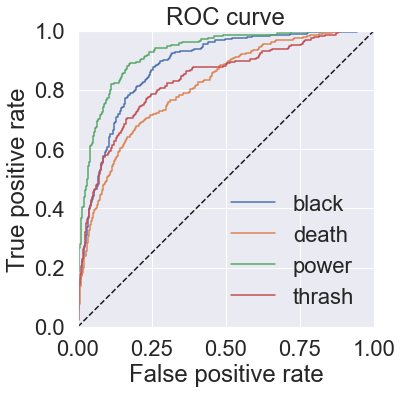

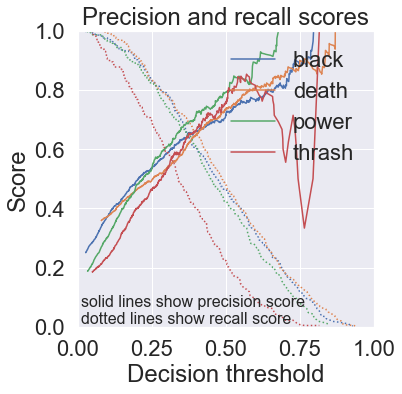

In [191]:
lr_params = dict(
    solver='lbfgs',
    max_iter=1000,
    random_state=0
)
pipeline = Pipeline(
    vectorizer=vectorizer,
    resampler=MLSOL(perc_gen_instances=0.3, k=5),
    classifier=BinaryRelevance(
        LogisticRegression(**lr_params),
        require_dense=[False, True]
    )
)
mlc, _ = multilabel_pipeline_cross_val(pipeline, X, y, labels=genres)
mlc.print_report()
best_thresh = mlc.thresh
if isinstance(best_thresh, float):
    best_thresh = np.ones(mlc.n_labels) * best_thresh
if len(best_thresh.shape) == 2:
    best_thresh = best_thresh.mean(0)
print("\nDecision thresholds:")
for i, label in enumerate(mlc.labels):
    print(f"  {label:<10s}: {best_thresh[i]:.2f}")
mlc.plot_roc_curve()
plt.show()
mlc.plot_precision_recall_curve()
plt.show()

In [193]:
pipeline.predict(['', 'satan', 'flesh', 'sword', 'kill'])

array([[0.32096534, 0.11188366, 0.0242947 , 0.10200252],
       [0.32096534, 0.11188366, 0.0242947 , 0.10200252],
       [0.31021969, 0.60125239, 0.00493851, 0.04208053],
       [0.29736811, 0.08367602, 0.04858577, 0.11670596],
       [0.14023745, 0.19209287, 0.01574448, 0.39675224]])

<a id='sgd'></a>
# SGD Classifier

The scikit-learn [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) is a generalized classifier that trains via stochastic gradient descent (SGD). It can assume the form of a logistic regression if using 'log' loss, but by default it uses the 'hinge' loss in which case the linear model it fits is a linear support vector machine (SVM).

fold 1/3
fold 2/3
fold 3/3

Binary classification metrics:

label: black
  balanced_accuracy   0.712
  precision           0.588
  recall              0.545
  f1                  0.565
  confusion matrix:
  [[   906    124]
   [   148    177]]

label: death
  balanced_accuracy   0.658
  precision           0.548
  recall              0.544
  f1                  0.546
  confusion matrix:
  [[   692    205]
   [   209    249]]

label: power
  balanced_accuracy   0.759
  precision           0.510
  recall              0.629
  f1                  0.563
  confusion matrix:
  [[  1018    127]
   [    78    132]]

label: thrash
  balanced_accuracy   0.667
  precision           0.438
  recall              0.452
  f1                  0.445
  confusion matrix:
  [[   995    132]
   [   125    103]]

Average binary classification scores:
  balanced_accuracy   0.70 +/- 0.08
  precision           0.52 +/- 0.11
  recall              0.54 +/- 0.13
  f1                  0.53 +/- 0.10

Multi-label clas

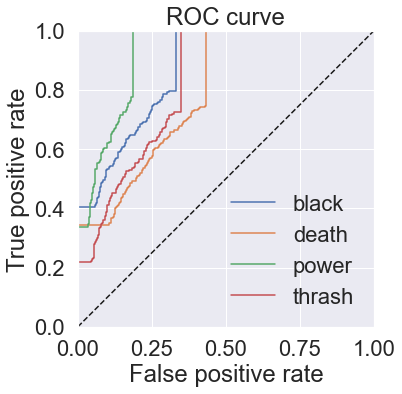

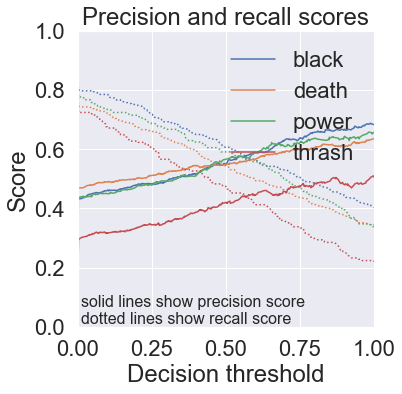

In [190]:
pipeline = Pipeline(
    vectorizer=vectorizer,
    resampler=MLSOL(perc_gen_instances=0.3, k=5),
    classifier=BinaryRelevance(
        SGDClassifier(loss='modified_huber', alpha=0.0001),
        require_dense=[False, True]
    )
)
mlc, _ = multilabel_pipeline_cross_val(pipeline, X, y, labels=genres)
mlc.print_report()
best_thresh = mlc.thresh
if isinstance(best_thresh, float):
    best_thresh = np.ones(mlc.n_labels) * best_thresh
if len(best_thresh.shape) == 2:
    best_thresh = best_thresh.mean(0)
print("\nDecision thresholds:")
for i, label in enumerate(mlc.labels):
    print(f"  {label:<10s}: {best_thresh[i]:.2f}")
mlc.plot_roc_curve()
plt.show()
mlc.plot_precision_recall_curve()
plt.show()

<a id='naivebayes'></a>
# Naive Bayes

[Naive Bayes classifiers](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) have long been popular in text classification. The method is rooted in Bayes' Theorem, which states the probability of a particular class $y$ given input $\mathbf{x}=(x_1, \dots, x_n)$ can be written as

$$ P(y|\mathbf{x}) = \frac{P(y)P(\mathbf{x}|y)}{P(\mathbf{x})} $$

where $P(y)$, $P(\mathbf{x}|y)$, and $P(\mathbf{x})$ are known as the prior, likelihood and evidence. The evidence is class-independent and can be ignored when comparing the probabilities of different classes, while the likelihood can be expanded using the chain rule for probabilities as

\begin{align}
P(\mathbf{x}|y) &= P(x_1, \dots, x_n|y)\\
                &= P(x_1|x_2, \dots, x_n, y) P(x_2, \dots, x_n|y)\\
                &= \dots\\
                &= P(x_1|x_2, \dots, x_n, y) P(x_2| x_3 \dots, x_n, y) \dots P(x_{n-1}|x_n, y) P(x_n|y) P(y)
\end{align}

The "naive" assumption is that the input variables $x_i$ are assumed to be mutually independent, so $P(x_i|x_{i+1}, \dots, x_n, y) = P(x_i|y)$. Thus the likelihood becomes a product sum of single-feature probabilities $P(x_i|y)$:

$$ P(\mathbf{x}|y) = P(y) \prod_{i=1}^{n} P(x_i|y) $$

Thus the Naive Bayes classification problem can be expressed as a maximum a posteriori estimation (like maximum-likelihood but with a prior term included that behaves like a regularization parameter (see [this blog post](https://wiseodd.github.io/techblog/2017/01/01/mle-vs-map/) for a quick discussion of MAP and MLE)) with the following classification rule:

$$ \hat{y} = \mathrm{argmax}_k P(y_k) \prod_{i=1}^{n} P(x_i|y_k) $$

The scikit-learn implementation [`NaiveBayes`](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes) provides different options for the likelihood distribution $P(x_i|y)$. The Multinomial and Bernoulli algorithms are the most popular for document classification tasks.

<a id='multinomialnb'></a>
### Multinomial Naive Bayes

fold 1/3


C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['insermi'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
D:\Documents\Projects\metallyrics\analyses\lyrics\mlsol.py:114: RuntimeWarning: invalid value encountered in double_scalars
  cd = dist_seed / (dist_seed - dist_reference)


fold 2/3


D:\Documents\Projects\metallyrics\analyses\lyrics\mlsol.py:114: RuntimeWarning: invalid value encountered in double_scalars
  cd = dist_seed / (dist_seed - dist_reference)


fold 3/3


D:\Documents\Projects\metallyrics\analyses\lyrics\mlsol.py:114: RuntimeWarning: invalid value encountered in double_scalars
  cd = dist_seed / (dist_seed - dist_reference)



Binary classification metrics:

label: black
  balanced_accuracy   0.728
  precision           0.435
  recall              0.616
  f1                  0.510
  confusion matrix:
  [[ 40663   7783]
   [  3736   5992]]

label: death
  balanced_accuracy   0.686
  precision           0.516
  recall              0.727
  f1                  0.603
  confusion matrix:
  [[ 24660  13603]
   [  5432  14479]]

label: heavy
  balanced_accuracy   0.695
  precision           0.377
  recall              0.580
  f1                  0.457
  confusion matrix:
  [[ 39380   9195]
   [  4035   5564]]

label: power
  balanced_accuracy   0.719
  precision           0.443
  recall              0.641
  f1                  0.524
  confusion matrix:
  [[ 37016   9447]
   [  4208   7503]]

label: thrash
  balanced_accuracy   0.651
  precision           0.324
  recall              0.548
  f1                  0.407
  confusion matrix:
  [[ 36083  11786]
   [  4655   5650]]

Average binary classification scores:
  b

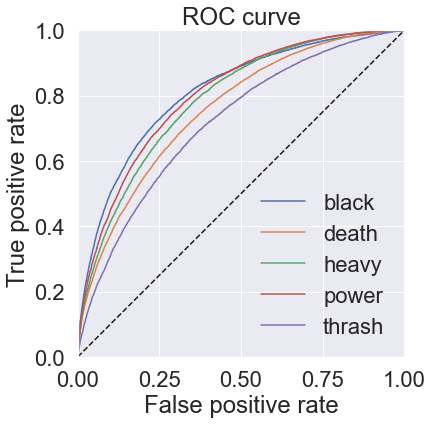

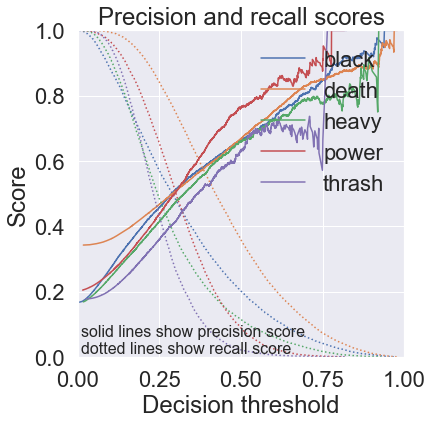

In [5]:
pipeline = Pipeline(
    vectorizer=TfidfVectorizer(stop_words=stopwords, max_features=3000),
    resampler=MLSOL(perc_gen_instances=0.3, k=5),
    classifier=BinaryRelevance(
        MultinomialNB(),
        require_dense=[False, True]
    )
)
mlc, _ = multilabel_pipeline_cross_val(pipeline, X, y, labels=genres)
mlc.print_report()
best_thresh = mlc.thresh
if isinstance(best_thresh, float):
    best_thresh = np.ones(mlc.n_labels) * best_thresh
if len(best_thresh.shape) == 2:
    best_thresh = best_thresh.mean(0)
print("\nDecision thresholds:")
for i, label in enumerate(mlc.labels):
    print(f"  {label:<10s}: {best_thresh[i]:.2f}")
mlc.plot_roc_curve()
plt.show()
mlc.plot_precision_recall_curve()
plt.show()

<a id='complementnb'></a>
### Complement multinomial Naive Bayes

fold 1/3


C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['insermi'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


fold 2/3
fold 3/3

Binary classification metrics:

label: black
  balanced_accuracy   0.717
  precision           0.451
  recall              0.575
  f1                  0.506
  confusion matrix:
  [[ 41641   6805]
   [  4133   5595]]

label: death
  balanced_accuracy   0.686
  precision           0.511
  recall              0.740
  f1                  0.605
  confusion matrix:
  [[ 24177  14086]
   [  5171  14740]]

label: heavy
  balanced_accuracy   0.500
  precision           0.667
  recall              0.000
  f1                  0.000
  confusion matrix:
  [[ 48574      1]
   [  9597      2]]

label: power
  balanced_accuracy   0.719
  precision           0.444
  recall              0.638
  f1                  0.524
  confusion matrix:
  [[ 37119   9344]
   [  4236   7475]]

label: thrash
  balanced_accuracy   0.651
  precision           0.326
  recall              0.544
  f1                  0.408
  confusion matrix:
  [[ 36304  11565]
   [  4701   5604]]

Average binary classifi

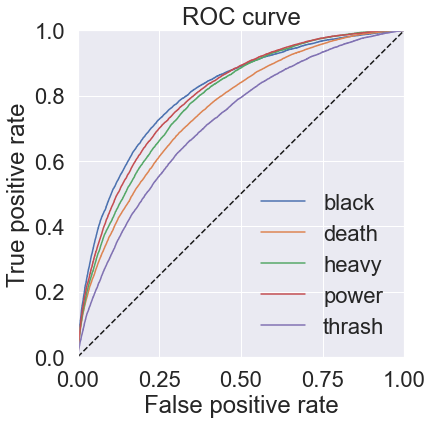

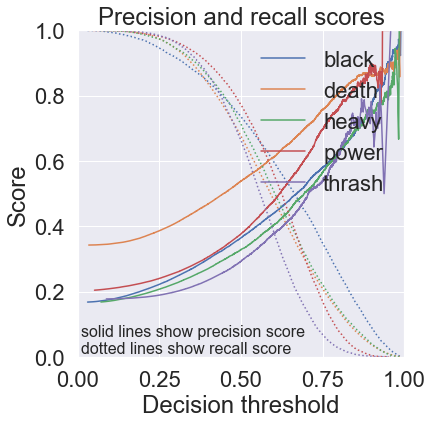

In [6]:
pipeline = Pipeline(
    vectorizer=TfidfVectorizer(stop_words=stopwords, max_features=3000),
    resampler=MLSOL(perc_gen_instances=0.3, k=5),
    classifier=BinaryRelevance(
        ComplementNB(),
        require_dense=[False, True]
    )
)
mlc, _ = multilabel_pipeline_cross_val(pipeline, X, y, labels=genres)
mlc.print_report()
best_thresh = mlc.thresh
if isinstance(best_thresh, float):
    best_thresh = np.ones(mlc.n_labels) * best_thresh
if len(best_thresh.shape) == 2:
    best_thresh = best_thresh.mean(0)
print("\nDecision thresholds:")
for i, label in enumerate(mlc.labels):
    print(f"  {label:<10s}: {best_thresh[i]:.2f}")
mlc.plot_roc_curve()
plt.show()
mlc.plot_precision_recall_curve()
plt.show()

<a id='bernoullinb'></a>
### Bernoulli Naive Bayes

fold 1/3


C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['insermi'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


fold 2/3
fold 3/3

Binary classification metrics:

label: black
  balanced_accuracy   0.708
  precision           0.408
  recall              0.587
  f1                  0.481
  confusion matrix:
  [[ 40145   8301]
   [  4013   5715]]

label: death
  balanced_accuracy   0.684
  precision           0.496
  recall              0.783
  f1                  0.607
  confusion matrix:
  [[ 22412  15851]
   [  4317  15594]]

label: heavy
  balanced_accuracy   0.693
  precision           0.383
  recall              0.565
  f1                  0.456
  confusion matrix:
  [[ 39818   8757]
   [  4172   5427]]

label: power
  balanced_accuracy   0.726
  precision           0.466
  recall              0.635
  f1                  0.538
  confusion matrix:
  [[ 37945   8518]
   [  4274   7437]]

label: thrash
  balanced_accuracy   0.500
  precision           0.000
  recall              0.000
  f1                  0.000
  confusion matrix:
  [[ 47869      0]
   [ 10305      0]]

Average binary classifi

C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  hamming loss  1.18

ROC AUC scores:
  black     : 0.800
  death     : 0.758
  heavy     : 0.780
  power     : 0.815
  thrash    : 0.720
  macro-avg : 0.774 +/- 0.034

Decision thresholds:
  black     : 0.46
  death     : 0.10
  heavy     : 0.60
  power     : 0.45
  thrash    : 1.00


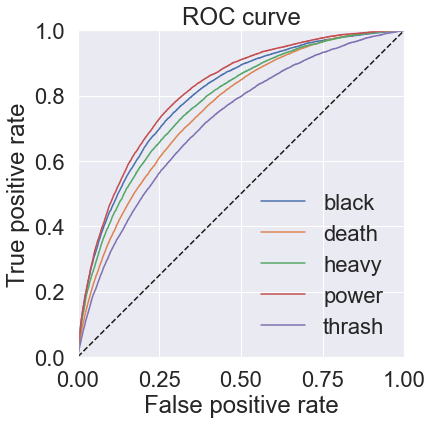

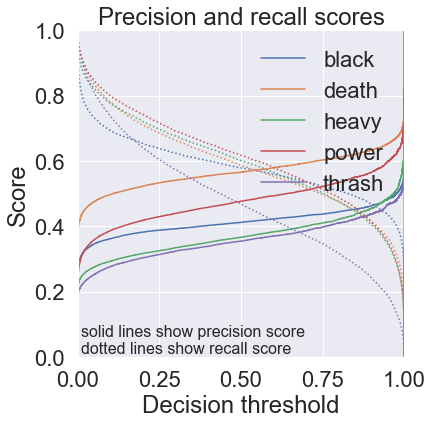

In [7]:
pipeline = Pipeline(
    vectorizer=TfidfVectorizer(stop_words=stopwords, max_features=3000),
    resampler=MLSOL(perc_gen_instances=0.3, k=5),
    classifier=BinaryRelevance(
        BernoulliNB(),
        require_dense=[False, True]
    )
)
mlc, _ = multilabel_pipeline_cross_val(pipeline, X, y, labels=genres)
mlc.print_report()
best_thresh = mlc.thresh
if isinstance(best_thresh, float):
    best_thresh = np.ones(mlc.n_labels) * best_thresh
if len(best_thresh.shape) == 2:
    best_thresh = best_thresh.mean(0)
print("\nDecision thresholds:")
for i, label in enumerate(mlc.labels):
    print(f"  {label:<10s}: {best_thresh[i]:.2f}")
mlc.plot_roc_curve()
plt.show()
mlc.plot_precision_recall_curve()
plt.show()

<a id='rf'></a>
# Random forest classifier

The random forest classifier is a popular choice in classification problems, especially when overfitting is a concern. As an ensemble model, the random forest does a good job of minimizing bias by averaging out the contributions of many hundreds or thousands of predictors.

fold 1/3
fold 2/3
fold 3/3

Binary classification metrics:

label: black
  balanced_accuracy   0.541
  precision           0.875
  recall              0.086
  f1                  0.157
  confusion matrix:
  [[  1026      4]
   [   297     28]]

label: death
  balanced_accuracy   0.523
  precision           0.885
  recall              0.050
  f1                  0.095
  confusion matrix:
  [[   894      3]
   [   435     23]]

label: power
  balanced_accuracy   0.510
  precision           1.000
  recall              0.019
  f1                  0.037
  confusion matrix:
  [[  1145      0]
   [   206      4]]

label: thrash
  balanced_accuracy   0.500
  precision           0.000
  recall              0.000
  f1                  0.000
  confusion matrix:
  [[  1127      0]
   [   228      0]]

Average binary classification scores:
  balanced_accuracy   0.52 +/- 0.03
  precision           0.69 +/- 0.80
  recall              0.04 +/- 0.07
  f1                  0.07 +/- 0.12

Multi-label clas

C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


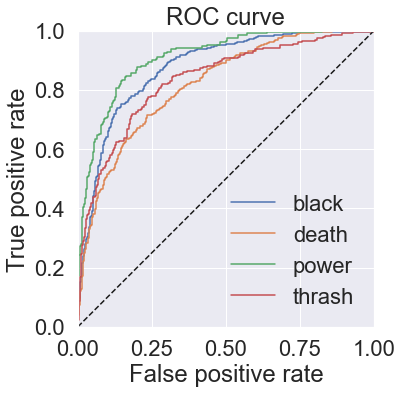

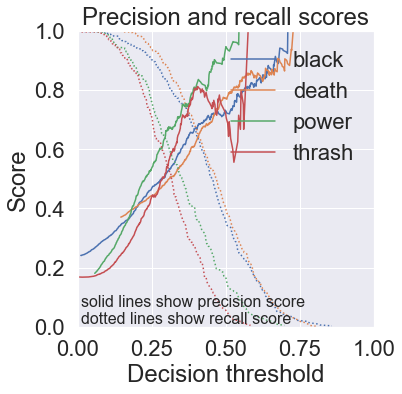

In [54]:
rf_params = dict(
    n_estimators=1000,
    max_depth=50,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    n_jobs=-1,
    random_state=0
)
pipeline = Pipeline(
    vectorizer=vectorizer,
    resampler=MLSOL(perc_gen_instances=0.3, k=5),
    classifier=BinaryRelevance(
        RandomForestClassifier(**rf_params),
        require_dense=[False, True]
    )
)
mlc, _ = multilabel_pipeline_cross_val(pipeline, X, y, labels=genres)
mlc.print_report()
best_thresh = mlc.thresh
if isinstance(best_thresh, float):
    best_thresh = np.ones(mlc.n_labels) * best_thresh
if len(best_thresh.shape) == 2:
    best_thresh = best_thresh.mean(0)
print("\nDecision thresholds:")
for i, label in enumerate(mlc.labels):
    print(f"  {label:<10s}: {best_thresh[i]:.2f}")
mlc.plot_roc_curve()
plt.show()
mlc.plot_precision_recall_curve()
plt.show()

### Feature importances

In [57]:
pipeline.fit(X, y)

black


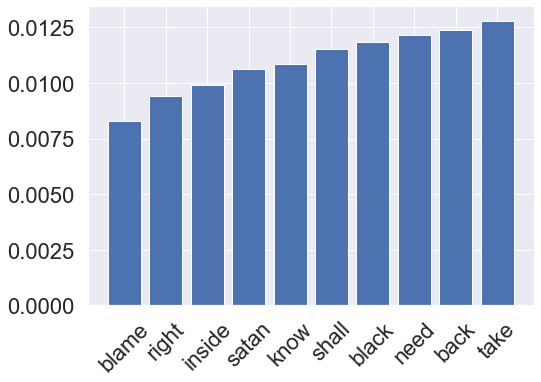

death


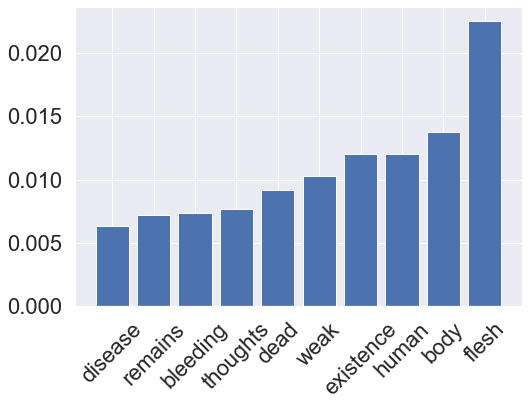

power


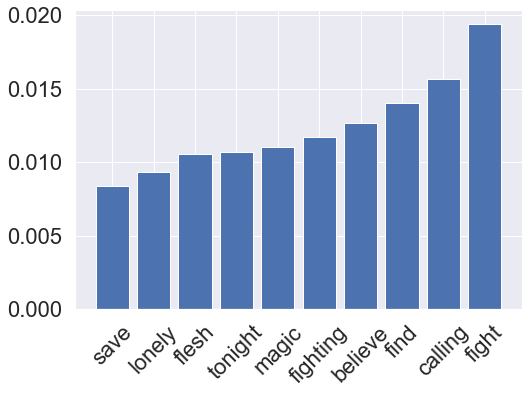

thrash


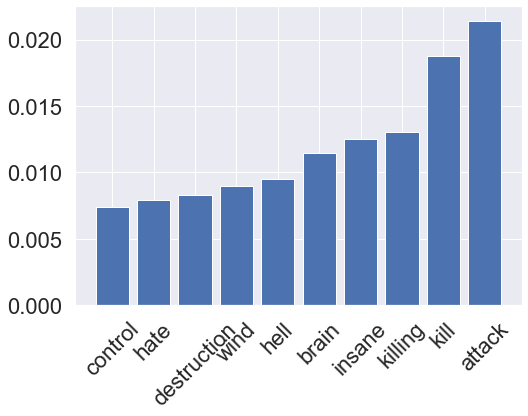

In [89]:
for genre, clf in zip(genres, pipeline.classifier.classifiers_):
    print(genre)
    fi = clf.feature_importances_
    fi_top = fi.argsort()[-10:]
    x_vals = range(len(fi_top))
    plt.bar(x_vals, fi[fi_top])
    plt.xticks(x_vals, vocab[fi_top], rotation=45)
    plt.show()

<a id='gbm'></a>
# Gradient boosting model

fold 1/3
fold 2/3
fold 3/3

Binary classification metrics:

label: black
  balanced_accuracy   0.528
  precision           0.905
  recall              0.058
  f1                  0.110
  confusion matrix:
  [[  1028      2]
   [   306     19]]

label: death
  balanced_accuracy   0.529
  precision           0.964
  recall              0.059
  f1                  0.111
  confusion matrix:
  [[   896      1]
   [   431     27]]

label: power
  balanced_accuracy   0.519
  precision           0.889
  recall              0.038
  f1                  0.073
  confusion matrix:
  [[  1144      1]
   [   202      8]]

label: thrash
  balanced_accuracy   0.504
  precision           0.667
  recall              0.009
  f1                  0.017
  confusion matrix:
  [[  1126      1]
   [   226      2]]

Average binary classification scores:
  balanced_accuracy   0.52 +/- 0.02
  precision           0.86 +/- 0.23
  recall              0.04 +/- 0.04
  f1                  0.08 +/- 0.08

Multi-label clas

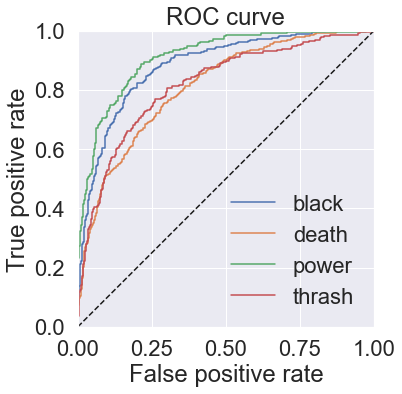

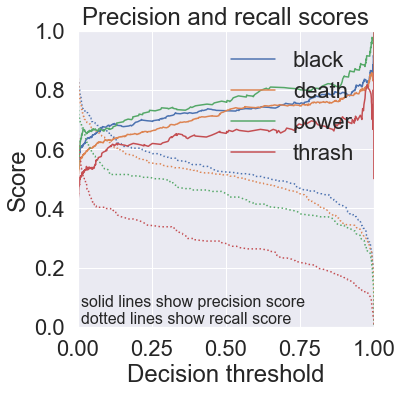

In [93]:
gbm_params = dict(
    n_estimators=1000,
    max_depth=30,
    n_jobs=-1,
    random_state=0
)
pipeline = Pipeline(
    vectorizer=vectorizer,
    resampler=MLSOL(perc_gen_instances=0.3, k=5),
    classifier=BinaryRelevance(
        lgb.LGBMClassifier(**gbm_params),
        require_dense=[False, True]
    )
)
mlc, _ = multilabel_pipeline_cross_val(pipeline, X, y, labels=genres)
mlc.print_report()
best_thresh = mlc.thresh
if isinstance(best_thresh, float):
    best_thresh = np.ones(mlc.n_labels) * best_thresh
if len(best_thresh.shape) == 2:
    best_thresh = best_thresh.mean(0)
print("\nDecision thresholds:")
for i, label in enumerate(mlc.labels):
    print(f"  {label:<10s}: {best_thresh[i]:.2f}")
mlc.plot_roc_curve()
plt.show()
mlc.plot_precision_recall_curve()
plt.show()

### Feature importances

black


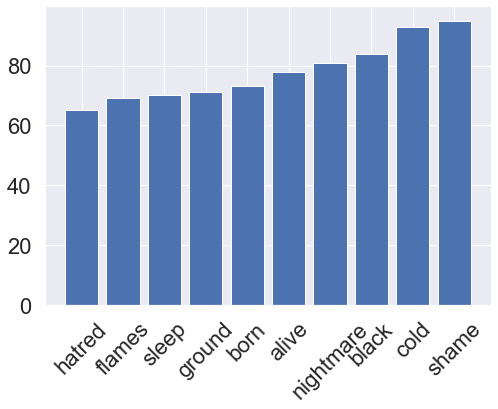

death


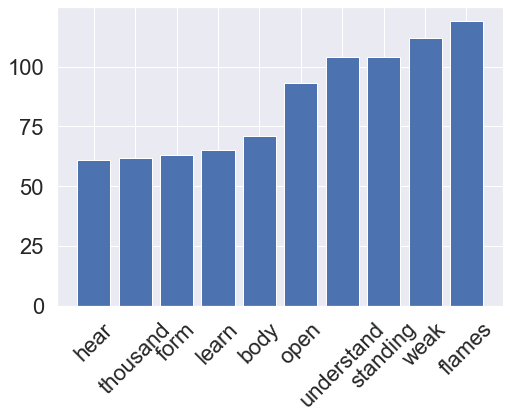

power


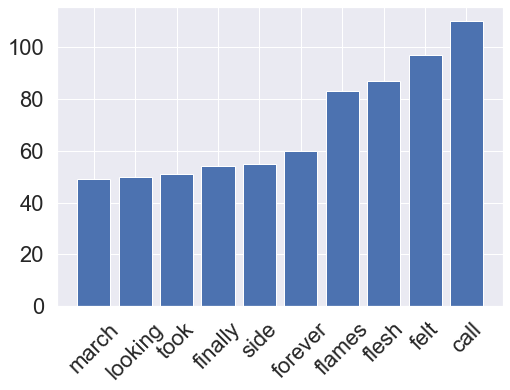

thrash


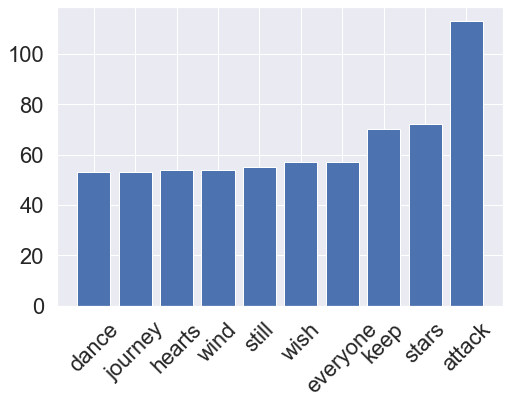

In [103]:
for genre, clf in zip(genres, pipeline.classifier.classifiers_):
    print(genre)
    fi = clf.feature_importances_
    fi_top = fi.argsort()[-10:]
    x_vals = range(len(fi_top))
    plt.bar(x_vals, fi[fi_top])
    plt.xticks(x_vals, vocab[fi_top], rotation=45)
    plt.show()

<a id='nn'></a>
# Neural network

In [ ]:
def create_keras_model(input_dim):
    model = Sequential()
    model.add(layers.Dense(64, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model

def keras_batch_generator(X_data, y_data, batch_size):
    number_of_batches = X_data.shape[0] // batch_size
    counter = 0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X_data[index_batch, :].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch), y_batch
        if counter > number_of_batches:
            counter = 0

In [ ]:
keras_params = dict(
    input_dim=3000,
    epochs=1,
    batch_size=512,
)
pipeline = Pipeline(
    vectorizer=TfidfVectorizer(stop_words=stopwords, max_features=3000),
    resampler=MLSOL(perc_gen_instances=0.3, k=5),
    classifier=BinaryRelevance(
        KerasClassifier(create_keras_model, **keras_params),
        require_dense=[False, True]
    )
)
mlc, _ = multilabel_pipeline_cross_val(pipeline, X, y, labels=genres)
mlc.print_report()
best_thresh = mlc.thresh
if isinstance(best_thresh, float):
    best_thresh = np.ones(mlc.n_labels) * best_thresh
if len(best_thresh.shape) == 2:
    best_thresh = best_thresh.mean(0)
print("\nDecision thresholds:")
for i, label in enumerate(mlc.labels):
    print(f"  {label:<10s}: {best_thresh[i]:.2f}")
mlc.plot_roc_curve()
plt.show()
mlc.plot_precision_recall_curve()
plt.show()

<a id='stacking'></a>
# Stacked model

In [ ]:
class StackedModel(BaseEstimator, TransformerMixin):
    def __init__(self, clfs=None, meta_clf=None):
        if clfs is not None:
            self.clfs = clfs
        else:
            self.clfs = []
        self.meta_clf = meta_clf

    def fit(self, X, y, split_test_size=0.2):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size)
        y_prob = np.zeros((X_test.shape[0], len(self.clfs)))
        for j, clf in enumerate(self.clfs):
            clf.fit(X_train, y_train)
            y_prob[:, j] = clf.predict_proba(X_test)[:, 1]
        self.meta_clf.fit(y_prob, y_test)
        return self

    def predict(self, X):
        return self.meta_clf.predict(self._predict_base(X))

    def predict_proba(self, X):
        return self.meta_clf.predict_proba(self._predict_base(X))

    def _predict_base(self, X):
        y_prob = np.zeros((X.shape[0], len(self.clfs)))
        for j, clf in enumerate(self.clfs):
            y_prob[:, j] = clf.predict_proba(X)[:, 1]
        return y_prob

In [ ]:
lgb_params = dict(
    n_estimators=1000,
    max_depth=30,
    n_jobs=-1,
    random_state=0
)
lr_params = dict(
    solver='lbfgs',
    max_iter=1000,
    random_state=0
)
stacked_model = StackedModel(
    [
        MultinomialNB(),
        BernoulliNB(),
        lgb.LGBMClassifier(**lgb_params),
    ],
    LogisticRegression(**lr_params)
)
pipeline = Pipeline(
    vectorizer=TfidfVectorizer(stop_words=stopwords, max_features=3000),
    resampler=MLSOL(perc_gen_instances=0.3, k=5),
    classifier=BinaryRelevance(stacked_model, require_dense=[False, True])
)
mlc, _ = multilabel_pipeline_cross_val(pipeline, X, y, labels=genres)
mlc.print_report()
best_thresh = mlc.thresh
if isinstance(best_thresh, float):
    best_thresh = np.ones(mlc.n_labels) * best_thresh
if len(best_thresh.shape) == 2:
    best_thresh = best_thresh.mean(0)
print("\nDecision thresholds:")
for i, label in enumerate(mlc.labels):
    print(f"  {label:<10s}: {best_thresh[i]:.2f}")
mlc.plot_roc_curve()
plt.show()
mlc.plot_precision_recall_curve()
plt.show()

## Stacking with NN

In [ ]:
lgb_params = dict(
    n_estimators=1000,
    max_depth=30,
    n_jobs=-1,
    random_state=0
)
lr_params = dict(
    solver='lbfgs',
    max_iter=1000,
    random_state=0
)
keras_params = dict(
    input_dim=3000,
    epochs=1,
    batch_size=512,
)
stacked_model = StackedModel(
    [
        MultinomialNB(),
        BernoulliNB(),
        lgb.LGBMClassifier(**lgb_params),
        KerasClassifier(create_keras_model, **keras_params)
    ],
    LogisticRegression(**lr_params)
)
pipeline = Pipeline(
    vectorizer=TfidfVectorizer(
        stop_words=stopwords, max_features=3000),
    resampler=MLSOL(perc_gen_instances=0.3, k=5),
    classifier=BinaryRelevance(stacked_model, require_dense=[False, True])
)
mlc, _ = multilabel_pipeline_cross_val(pipeline, X, y, labels=genres)
mlc.print_report()
best_thresh = mlc.thresh
if isinstance(best_thresh, float):
    best_thresh = np.ones(mlc.n_labels) * best_thresh
if len(best_thresh.shape) == 2:
    best_thresh = best_thresh.mean(0)
print("\nDecision thresholds:")
for i, label in enumerate(mlc.labels):
    print(f"  {label:<10s}: {best_thresh[i]:.2f}")
mlc.plot_roc_curve()
plt.show()
mlc.plot_precision_recall_curve()
plt.show()

<a id='test'></a>
# Test on select lyrics

In [ ]:
# lr_params = dict(
#     solver='lbfgs',
#     max_iter=1000,
#     random_state=0
# )
# pipeline = Pipeline(
#     vectorizer=TfidfVectorizer(stop_words=stopwords, max_features=3000),
#     resampler=MLSOL(perc_gen_instances=0.3, k=5),
#     classifier=BinaryRelevance(
#         LogisticRegression(**lr_params),
#         require_dense=[False, True]
#     )
# )

pipeline = Pipeline(
    vectorizer=TfidfVectorizer(stop_words=stopwords, max_features=3000),
    resampler=MLSOL(perc_gen_instances=0.3, k=5),
    classifier=BinaryRelevance(
        MultinomialNB(),
        require_dense=[False, True]
    )
)
pipeline.fit(X, y)

In [179]:
def classify_text(text):
    X_test = np.array([' '.join(text.lower().split())])
    prob = pipeline.predict(X_test)[0]
    pred = prob > best_thresh
    genre_results = [(genre, prob[i], pred[i]) for i, genre in enumerate(genres)]
    genre_results.sort(key=lambda x: 1 - x[1])
    print("Classification:")
    if genre_results[0][2] < 1:
        print("NONE")
    else:
        print(", ".join([res[0].upper() for res in genre_results if res[2] > 0]))
    print("\nIndividual genre probabilities:")
    for res in genre_results:
        print("{:<10s}{:>3.0f}%".format(res[0], 100 * res[1]))
    return

In [194]:
# Deathspell Omega
classify_text("""
Our skies are forever black
Here is no signs of life at all
For burning spirits we are
Consuming your small universe
Slowly but surely
No one believes in us
We came from realms of Hell
No eyes can see us
We're not made of flesh and blood
In times past we reigned everywhere
One day life emerged from the chaos
We still dominate but this error must end
The void shall swallow the decease
Slowly but surely
Changing from a dimention to another..
of being possession
Out of the nihilistic kingdom
to spread destruction
An unseen invasion to conquer
the spiled land...till total extinxion
The human claim to rule their world
They don't even understand the meaning
of death
A black hole is eating each soul
The ultimate desolation will supress
life and prevail again
Then there won't be mistakes anymore
The apotheosis of Satan approaches
He who is inside of us
""")

Classification:
DEATH, BLACK

Individual genre probabilities:
death      52%
black      48%
thrash      7%
power       3%


In [195]:
# Lamb of God
classify_text("""
If there was a single day I could live... a single breath I could take
I'd trade all the others away.
The blood's on the wall, so you'd might as well just admit it
And bleach out the stains, commit to forgetting it.
You're better off empty and blank, than left with a single pathetic trace of this
Smother another failure, lay this to rest.
Console yourself, you're better alone
Destroy yourself, see who gives a fuck
Absorb yourself, you're better alone
Destroy yourself.
I'll chain you to the truth, for the truth shall set you free
I'll turn the screws of vengeance and bury you with honesty
I'll make all your dreams come to life, then slay them as quickly as they came
Smother another failure, lay this to rest.
Console yourself, you're better alone
Destroy yourself, see who gives a fuck
Absorb yourself, you're better alone
Destroy yourself, see who gives a fuck.
Failure.
If there was a day I could live, if there was a single breath I could take
I'd trade all the others away.
""")

Classification:
NONE

Individual genre probabilities:
black      24%
thrash     11%
death      10%
power       5%


In [196]:
# Nokturnal Mortum
classify_text("""
The edge of continuity for dream and reality.
Shaman is dancing his dance of death;
the masks of the demonssurrounding me.
This is my wedding ritual that gives the violence.
The fog of the night, the dark water...
to run through the expanse of light.
The mysteries of civilizations
that left the Earth more of ten times return to me;
it gives no repose to me again and again.
Standing in the forestand seeing the atricities...
all is inside me, and it comes back in the dreams.
The shaman dances, the masks are waiting for its demon.
The knife is in my hand.
The fog... will never crawl away.
My words are devoured by the bestial of silence
and in invisible chains shackle my moves.
The dream continues it's gush to reality
and the shaman drums louder the rhytm to his dance of death.
""")

Classification:
NONE

Individual genre probabilities:
black      29%
death      12%
thrash     10%
power       4%


In [197]:
# Waking the Cadaver
classify_text("""
Full force assault,
With my arsenal,
Of destruction,

Seeing the neighborhood,
With a horrid stare,
Blasting authority,

You will never catch me,
On my killing spree,
Appetite for death,
Realize there is no God.

You will never catch me,
On my killing spree,
Appetite for death,
Realize there is no God.

Full force assault,
With my arsenal,
Of destruction,

Seeing the neighborhood,
With a horrid stare,
Blasting authority,

You will never catch me,
On my killing spree,
Appetite for death,
Realize there is no God.
""")

Classification:
THRASH

Individual genre probabilities:
thrash     36%
black      20%
death      18%
power       2%


In [198]:
# Wolves in the Throne Room
classify_text("""
The journey is long and steep
Sweat turns lack and runs with dust
Here I seek the edge of the world
The secrets that lie behind the veil
The rapture of the universe

As the sun pours down like honey
Three sentries loom at the skyline
Bravely staring on
Our sun of eternity pours down as it shines bright

Many souls slumber
On the mountainside below
Dressed in royal robes of green and red

My left hand points to the earth
My right towards the starry sky
Writhing serpent belt of eternity
Wrapped round my waist
Black banner blows in the wind
Emblazoned with the white rose of death

Under the cover of night, by fire light
Blood smoke in my lungs
Moss and blood in my hair
Ash in my eyes, I grip the torch
My light illuminates her ritual
Lost sigil burns in the dark
Her ecstasy shakes the cannon
The future now glows with a blue brilliance
In my mind's eye I can see a stronghold
With a moat of pure spring water
Spires of cedar and fir
""")

Classification:
BLACK

Individual genre probabilities:
black      40%
death      10%
thrash      6%
power       5%


In [199]:
# Ne Obliviscaris
classify_text("""
ALL HORIZONS FALL THROUGH DYING STAINS
A CRIMSON CROWN TO CALL MY OWN
O HOME IS EVERYWHERE I VOYAGE
AND DARKNESS IS ALWAYS WITH ME...

I CALL TO THE SIRENS ECHOING IN SWEET LAUGHTER
BROKEN HOPES 'NEATH THE SURFACE
WITH HAUNTING EYES THEY STARE...
through black waters, wearing tresses
a figurehead warped, stares homesick afar

NEVER DEPTHS... MY DEAR DESPAIR
NEVER

BLIND IN DELIRIUM, NAVIGATING THE CONTINUUM FLUX... NOTHING
SUBMERGED IN LIMBO, OF NAUTICA THEY SING... TRUE MAJESTY
OCEANS WIDE, EYES WIDE... FOREVER TO TREASURE... CARRY ON
INFUSING INSIGHT, THE FABRIC OF SPACE IGNITED

silent time reveals tragedies chartered
all triumphs were drowned...and the sirens too...
SILENT TIME REVEALS...
ALL TRIUMPHS WERE DROWNED...
symphony for the pilgrim, intrinsic wake, opulent discordant soul... my arabesque
setting sail from paradox lost to a paradise found
PARADISE, PARADISE FOUND
PARADISE, PARADISE FOUND
""")

Classification:
NONE

Individual genre probabilities:
black      26%
death      13%
power       6%
thrash      5%


In [200]:
# Car Bomb
classify_text("""
Dark smiles saying nothing
The warpath, straight and lonely
Both sides feel the cold front closing in

Reveal the frozen pieces of earth

Can’t hear the hidden sounds from its closed mouth
No more secret truths said into the soundproof walls

They sing we’re restored to life

From the dust of this planet you sing
Stand up and sing
Ashes in ears
There’s no way home
Just sing this song

They sing we’re restored to life
Pull the rusting nails from these walls
Peel off your broken nails

Wake wake up the sun
Just take it all back
""")

Classification:
NONE

Individual genre probabilities:
black      21%
thrash      8%
power       4%
death       4%


In [201]:
# Death Angel
classify_text("""
Metal mayhem; hit the stage
Thrashing to the madness,
You can feel the rage!

Denim, leather, in the crowd
Feel your ears are bleeding,
Wanna hear it loud!

Thrasher! [4x]

Posers strike us in the back
I can’t take their bullshit,
Turn around and attack
(Attack!)

Metal bodies slamming into me,
How I live my life
And baby can’t you see?

Thrashers! [4x]

Smashing, thrashing, on your knees
You beg for mercy
Smashing, thrashing, on your knees
You plead for mercy

Thrasher! [4x]

Fighting, fall off the stage
Screaming with a rage
Thrashing, lose control
Smashing I like drugs
Madness, all around
Falling to the ground
Dying for your breath
Living to your death

Thrashing, smashing, on their knees
You beg for mercy
Thrashing, smashing, on their knees
You plead for mercy

Thrasher! [4x]
""")

Classification:
THRASH

Individual genre probabilities:
thrash     41%
death      18%
black      15%
power       4%


In [202]:
# Fleshgod Apocalypse
classify_text("""
Bow your head before your king, as I’m the bringer of light
The chosen one amongst all men, the lord and master of light
“But who decided it all?”
Shut up you servant,, respect divine right
For I belong to the elite of mankind
Enlightened guardian of justice and right
My word is law or it’s eye for an eye

Bow down before the sovereign of the kingdom
I will lead you through the hardest times
Devote we are to the crown, in sole command forever glorious

Hail: Long live the great king!

Born with the fire inside
The flame of wisdom burns in my noble heart
Turns into guiding light that blows the mist on the path
“We’ll follow you ‘till the end!”
Balance of power, the art of the wise
Ancestral pride to preserve for my bloodline
Resounds my name through spirals of time
Until kingdom come I

God bless my soul, guide my fury through this cold war
Hunting Judas down
Now free my hands from the spires of the serpent
Death to the traitors of the crown

No one to trust and no one to save
As this court is a den of snakes
Walk alone through this treacherous world
Mutilating the venomous tongue
Your misleading words, hide desire to prevail
In this devious show, fail

No one is virtuous, no one is grown
No one deserves to be heir to the throne
‘Till their veins will be filled with their gall
I will stand for the sake of the sacred crown
Forever at war
You deceiving worms will be smashed by my rage
In the name of god, slayed

In aeternam, draining struggle to serve my reign
With full force restore the integrity
Purify consciences through blood
Extirpate those cancers, dictate my law
‘Till the day of my fall
Beware you’ll pay for your faults
""")

Classification:
BLACK

Individual genre probabilities:
black      51%
power      17%
death      15%
thrash     10%


In [203]:
# Protest the Hero
classify_text("""
Without a word uttered
A comparison is drawn.
A distant future, a cluttered past
Amid the stars.
Vague yet persistent, 
Thought lacking consistency.
Unwilling victim of farce.
The loudest voices scream uninspired.
Their numbers vast, their spirits strong.
Quiet choices sing against the choir
The majority is almost never wrong...
Never wrong... Ever... Never wrong.

A laughable assertion
That there might be some connection
(smoke-filled halls)
Adorn the walls with mirrors and misdirection,
Or let it go. [4x]

No common thread, 
No ties that bind.
Just grasping at threads and keep in mind.
Historical analysis
They play a separate role,
But one contributes more to the whole!

Like a saucer sep...
Let's separate and shuffle off this conflict.
My armament will suffocate (will suffocate),
And leave you feeling useless.

We are your beginning 
And we will be your end.
Affluence permitting, a mutual annihilation.

A laughable assertion
That there might be some connection
(smoke-filled halls)
Adorn the walls with mirrors and misdirection,
Or let it go. [4x]

Discussion moot
Argument ended
An aggressive mute
Strumbling defendant
Fiction versus fantasy
One fact remains unclear
How you pretend both franchises stand soley on one tier?!

We are your beginning 
And we will be your end.
Affluence permitting, a mutual annihilation.

I don't care who shot first
Or for the song and dance you've rehearsed.
(a mutual annihilation)
I don't care who shot first,
Or for the song and dance that you've rehearsed.

The maps are divided
And each are traversed.
Aligment in flux for better or worse.
Is the drain finally swirling or are we swirling the drain?
This drought is relieved with acid rain.

This drought is relieved with acid rain. [3x]

(we are) We are your beginning (and the end)
And we will be your end (we will be your end) [2x]

Affluence permitting a mutual annihilation
""")

Classification:
NONE

Individual genre probabilities:
black      17%
thrash     11%
death       6%
power       6%
